In [ ]:
import kagglehub
kavyasreeb_hair_type_dataset_path = kagglehub.dataset_download('kavyasreeb/hair-type-dataset')

print('Data source import complete.')
# https://www.kaggle.com/datasets/kavyasreeb/hair-type-dataset

100%|██████████| 175M/175M [00:04<00:00, 42.8MB/s]

Extracting files...


Data source import complete.


# Hair styles tendencies

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights

from torchvision import transforms

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from copy import deepcopy

import os

from PIL import Image

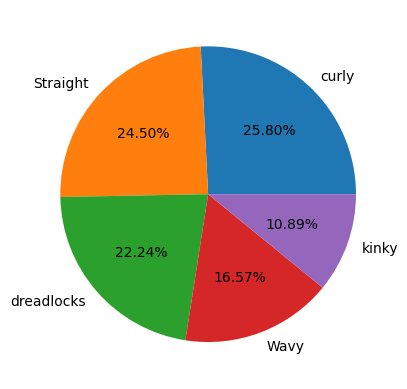

In [ ]:

def create_df(path):
    dd = {"images": [], "labels": []}
    for i in os.listdir(path):
        styles = os.path.join(path, i)
        for j in os.listdir(styles):
            dd["images"] += [os.path.join(styles, j)]
            dd["labels"] += [i]

    return pd.DataFrame(dd)


df = create_df("/root/.cache/kagglehub/datasets/kavyasreeb/hair-type-dataset/versions/1/data")

df["labels"].value_counts().plot(kind="pie", autopct="%0.2f%%")
plt.xlabel("")
plt.ylabel("")
plt.show()

label_index = {"Straight": 0,
              "Wavy": 1,
              "curly": 2,
              "dreadlocks": 3,
              "kinky": 4}

index_label = dict()

for i, j in label_index.items():
    index_label[j] = i

df["labels"] = df["labels"].map(label_index)

EPOCHS = 5
LR = 0.1
IMG_SIZE = 224
BATCH = 32

class Pipeline(Dataset):
    def __init__(self, data, transform):
        super(Pipeline, self).__init__()
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, x):
        img, label = self.data[x, 0], self.data[x, 1]
        img = Image.open(img).convert("RGB")
        img = np.array(img)
        img = self.transform(img)

        return img, label

transform = transforms.Compose([transforms.ToPILImage(),
                              transforms.ToTensor(),
                              transforms.Resize((IMG_SIZE, IMG_SIZE)),
                               transforms.RandomHorizontalFlip(p=0.3),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train, validation = train_test_split(df.values, random_state=42, test_size=0.2)
val, test = train_test_split(validation, random_state=42, test_size=0.5)

train_ds = Pipeline(train, transform)
val_ds = Pipeline(val, transform)

train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=False)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

class HairStyle(nn.Module):
    def __init__(self, model):
        super(HairStyle, self).__init__()
        self.model = model

    def forward(self, x):
        return nn.functional.softmax(self.model(x), dim=1)

# Fine-tuning ResNet50 for Hair Style detection

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 149MB/s]


Epoch 1 train loss 0.04514048096524494 acc 0.5342121782799749 val loss 0.041909619192382196 acc 0.7587939698492462
Epoch 2 train loss 0.03500533878466504 acc 0.8305084745762712 val loss 0.037250877025738434 acc 0.8743718592964824
Epoch 3 train loss 0.031268626208284404 acc 0.9296924042686755 val loss 0.03547884471452416 acc 0.9095477386934674
Epoch 4 train loss 0.02999528649462444 acc 0.9591964846202135 val loss 0.03503478352148928 acc 0.9296482412060302
Epoch 5 train loss 0.029442180235731624 acc 0.975517890772128 val loss 0.03512021375061879 acc 0.9095477386934674


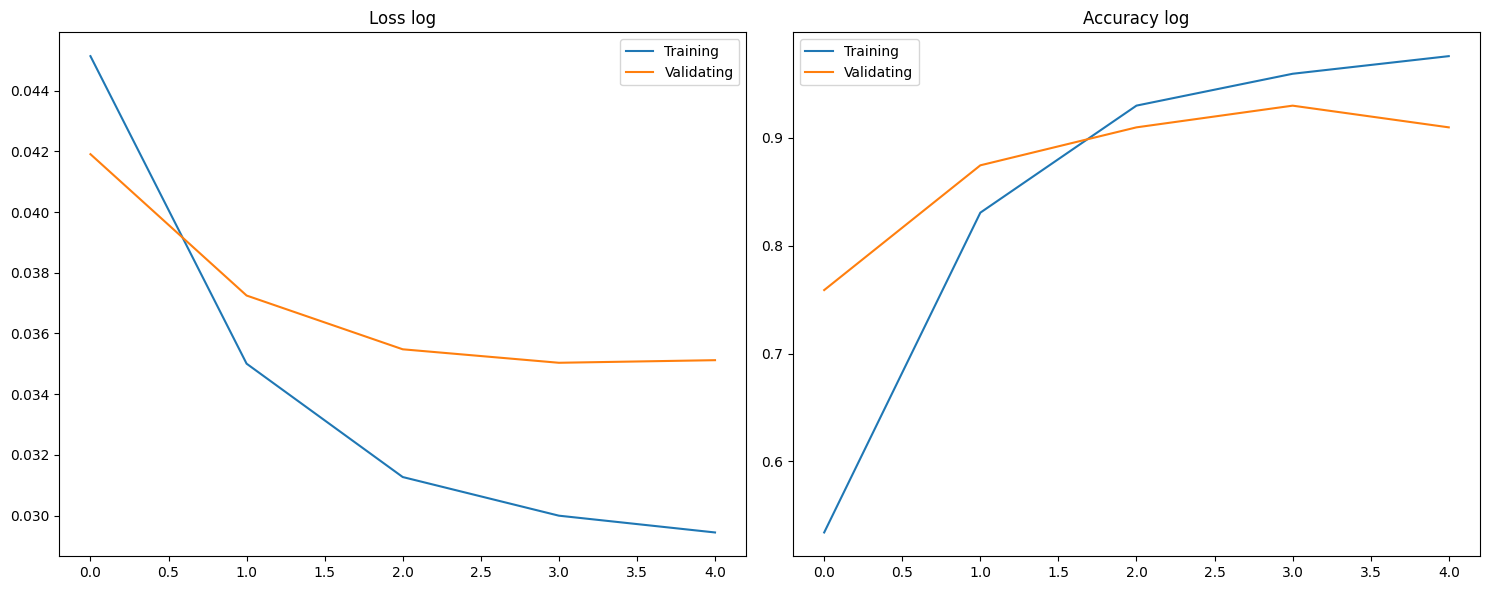

In [ ]:
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 5)

model = HairStyle(resnet)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for i in range(1, EPOCHS+1):
    model.train()

    diff = 0
    acc = 0
    total = 0

    for data, target in train_dl:
        optimizer.zero_grad()
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        out = model(data)
        loss = criterion(out, target)
        diff += loss.item()
        acc += (out.argmax(1) == target).sum().item()
        total += out.size(0)
        loss.backward()
        optimizer.step()

    train_loss += [diff/total]
    train_acc += [acc/total]

    diff = 0
    acc = 0
    total = 0

    model.eval()

    with torch.no_grad():
        for data, target in val_dl:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)

    val_loss += [diff/total]
    val_acc += [acc/total]

    if val_acc[-1] >= best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)

    print("Epoch {} train loss {} acc {} val loss {} acc {}".format(i, train_loss[-1], train_acc[-1],
                                                                   val_loss[-1], val_acc[-1]))


fig, axes = plt.subplots(ncols=2, figsize=(15, 6))

index = 0
axes[index].plot(train_loss, label="Training")
axes[index].plot(val_loss, label="Validating")
axes[index].legend()
axes[index].set_title("Loss log")
axes[index].set_xlabel("")
axes[index].set_ylabel("")

index += 1

axes[index].plot(train_acc, label="Training")
axes[index].plot(val_acc, label="Validating")
axes[index].legend()
axes[index].set_title("Accuracy log")
axes[index].set_xlabel("")
axes[index].set_ylabel("")

plt.tight_layout()
plt.show()

def predict(img):
    img = Image.open(img).convert("RGB")
    img = np.array(img)
    img = transform(img)
    img = img.view(1, 3, 224, 224)
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()

    out = best_model(img)

    index = out.argmax(1).item()

    return index, out[0][index].item()


truth = []
preds = []
probas = []

for i in range(test.shape[0]):
    truth += [test[i, 1]]
    pred, proba = predict(test[i, 0])
    preds += [pred]
    probas += [round(proba*100, 2)]

# Model evaluation: classification report, score and visual inspection of obtained results

              precision    recall  f1-score   support

           0       1.00      0.89      0.94        47
           1       0.89      0.89      0.89        36
           2       0.88      0.90      0.89        51
           3       0.96      1.00      0.98        53
           4       0.80      0.92      0.86        13

    accuracy                           0.93       200
   macro avg       0.91      0.92      0.91       200
weighted avg       0.93      0.93      0.93       200



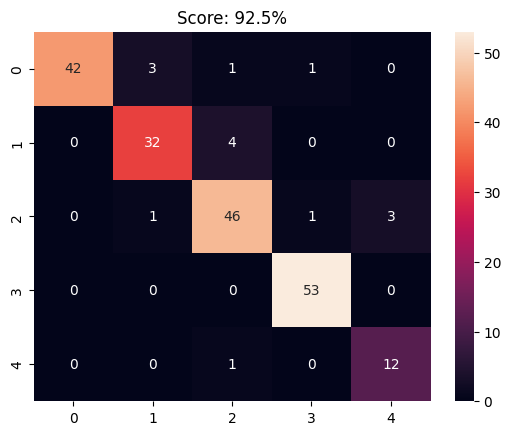

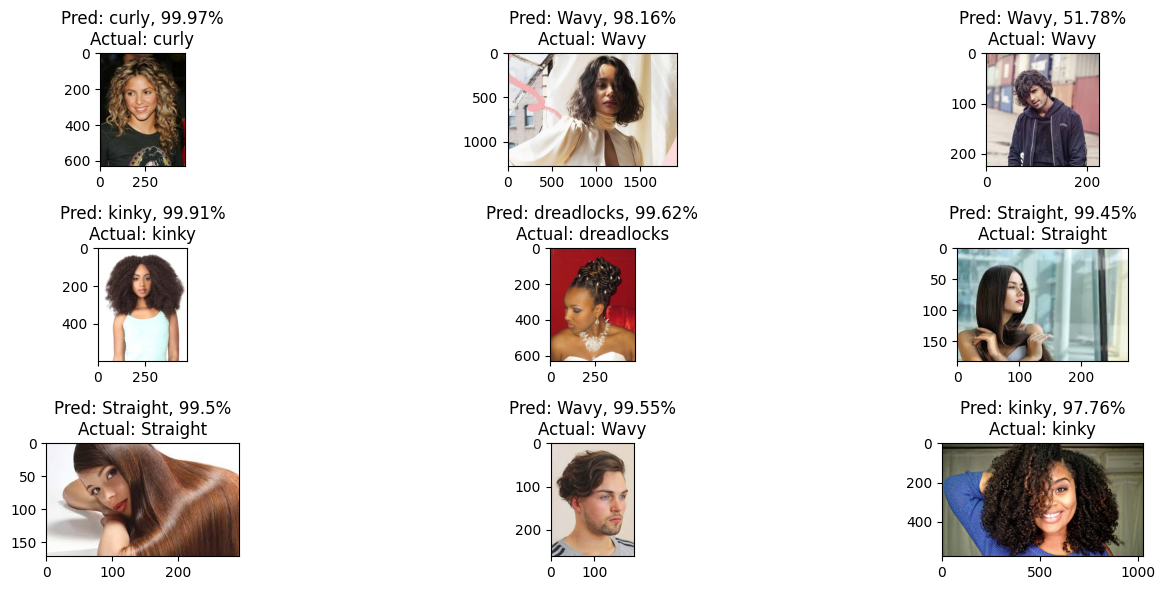

In [ ]:
print(classification_report(preds, truth))
sns.heatmap(confusion_matrix(preds, truth), annot=True, fmt='d')
plt.title("Score: {}%".format(round(accuracy_score(preds, truth)*100, 2)))
plt.show()

index = 0

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 6))
for i in range(3):
    for j in range(3):
        axes[i][j].imshow(np.array(Image.open(test[index, 0]).convert("RGB")))
        axes[i][j].set_title("Pred: {}, {}%\nActual: {}".format(index_label[preds[index]],
                                                               probas[index],
                                                               index_label[truth[index]]))
        index += 1
plt.tight_layout()
plt.show()

In [ ]:
# prompt: make pth file of model

# This code creates a file named 'hair_style_model.pth' which contains the trained model.
# Note:  This code assumes the training and evaluation code from your previous example
# has been executed and the 'best_model' variable is available.  If not, you'll need to
# include that code here before this section.

import torch

# Save the trained model
torch.save(best_model.state_dict(), 'hair_style_model.pth')

print("Model saved to hair_style_model.pth")


Model saved to hair_style_model.pth


Predicted hair style for /root/.cache/kagglehub/datasets/kavyasreeb/hair-type-dataset/versions/1/data/kinky/images17.jpg: kinky with confidence 1.00
Actual hair style for /root/.cache/kagglehub/datasets/kavyasreeb/hair-type-dataset/versions/1/data/kinky/images17.jpg: kinky


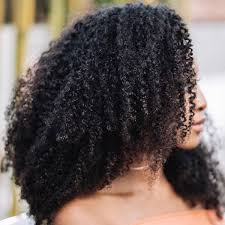

In [ ]:
# prompt: load pth model and and get random picture from dataset and test

import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
from PIL import Image
import numpy as np
import random
import os

# Load the saved model
class HairStyle(nn.Module):
    def __init__(self, model):
        super(HairStyle, self).__init__()
        self.model = model

    def forward(self, x):
        return nn.functional.softmax(self.model(x), dim=1)

resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 5)

model = HairStyle(resnet)
model.load_state_dict(torch.load('hair_style_model.pth'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Define image transformations
IMG_SIZE = 224
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Function to predict the hair style
def predict(img_path):
    img = Image.open(img_path).convert("RGB")
    img = np.array(img)
    img = transform(img)
    img = img.view(1, 3, 224, 224).to(device)
    with torch.no_grad():
        out = model(img)
    index = out.argmax(1).item()
    return index, out[0][index].item()

# Get a random image from the dataset
dataset_path = "/root/.cache/kagglehub/datasets/kavyasreeb/hair-type-dataset/versions/1/data"  # Replace with the actual path to your dataset

image_files = []
for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):
          image_files.append(os.path.join(root, file))
random_image_path = random.choice(image_files)

# Predict the hair style of the random image
predicted_class, confidence = predict(random_image_path)

index_label = {0: "Straight", 1: "Wavy", 2: "curly", 3: "dreadlocks", 4: "kinky"}

print(f"Predicted hair style for {random_image_path}: {index_label[predicted_class]} with confidence {confidence:.2f}")
# print actual
print(f"Actual hair style for {random_image_path}: {os.path.basename(os.path.dirname(random_image_path))}")


# show image
from IPython.display import Image
Image(filename=random_image_path)
